<h1 align="center">Stone Soup SPIE Use Case</h1>
<h3 align="center">Demonstrating the capabilities of Stone Soup at Beta release with Kalman based tracker<h3>
<h4 align="center">Dstl © Crown Copyright, 2019</h4>

First we'll set up some initial imports and set up plotting which we'll use later.

In [1]:
#General imports and plotting
import datetime
import numpy as np

# Plotting
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-colorblind')

Generating Data
----------------
First we'll create some models, which will be used to generate data.

This will include a 2D-position constant velocity transition model ($x$, $\dot{x}$, $y$ and $\dot{y}$), generated by combining two 1D models (this allows multiple models to be mixed and generation of *n*-dimension models).

In [2]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel,\
                                               ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel(
    (ConstantVelocity(1), ConstantVelocity(1)))

And a measurement model, which will map the position based detections ($x$ and $y$) to the position in the state.

In [3]:
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    ndim_state=4, mapping=[0, 2], noise_covar=np.diag([10, 10]))

Next we'll create a multi-target ground truth simulation in order to generate some data for testing the tracking algorithm. This utilises the *transition model* to generate the ground truth paths, initialised at random by sampling from a *Gaussian State*. A ground truth track/path at each timestamp is created at a random *birth rate* ($\lambda$ in Poisson distribution), and randomly killed by a *death probability*.

In [4]:
from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator
from stonesoup.types.state import GaussianState
from stonesoup.types.array import StateVector, CovarianceMatrix

groundtruth_sim = MultiTargetGroundTruthSimulator(
    transition_model=transition_model,
    initial_state=GaussianState(
        StateVector([[0], [0], [0], [0]]),
        CovarianceMatrix(np.diag([1000000, 10, 1000000, 10]))),
    timestep=datetime.timedelta(seconds=5),
    number_steps=60,
    birth_rate=0.8,
    death_probability=0.05
)

Next we'll create a detection simulator, which will generate detections based on a *detection probability* about the ground truth, utilising the *measurement model*. This model will also create clutter in our defined *measurement range*.

In [5]:
from stonesoup.simulator.simple import SimpleDetectionSimulator

detection_sim = SimpleDetectionSimulator(
    groundtruth=groundtruth_sim,
    measurement_model=measurement_model,
    meas_range=np.array([[-1, 1], [-1, 1]])*5000,  # Area to generate clutter
    detection_probability=0.9,
    clutter_rate=3,
)

Building Kalman tracker components
------------------------------------

With the detection data ready, we'll now build a Kalman tracker. For this we will need a Kalman predictor, which will utilise the same *transition model* we used in the ground truth simulator.

In [6]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

And a Kalman updater, utilising the same *measurement model* we used in the detection simulator.

In [7]:
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

We will also need a data associator to link detections to the "correct" track for the update step: in this case a Nearest Neighbour is fine. The data associator requires a hypothesiser, which calculates some form of score/probability of each track being associated to each detection: in this case using a Mahalanobis distance from track prediction to the detection (which will also generate missed detection hypothesis).

In [8]:
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
hypothesiser = DistanceHypothesiser(predictor, updater, Mahalanobis(), missed_distance=3)

In [9]:
from stonesoup.dataassociator.neighbour import NearestNeighbour
data_associator = NearestNeighbour(hypothesiser)

And finally a initiator to generate tracks from unassociated detections, in this case a single point initiator generating a track for every unassociated detection.

In [10]:
from stonesoup.initiator.simple import SinglePointInitiator
initiator = SinglePointInitiator(
    GaussianState(np.array([[0], [0], [0], [0]]), np.diag([10000, 100, 10000, 1000])),
    measurement_model=measurement_model)

And a deleter to remove tracks, for this demo it is simply based on large covariance threshold.

In [11]:
from stonesoup.deleter.error import CovarianceBasedDeleter
deleter = CovarianceBasedDeleter(covar_trace_thresh=1E3)

And now with all the components in place, we'll construct a tracker as a multi-target tracker.

In [12]:
from stonesoup.tracker.simple import MultiTargetTracker
kalman_tracker = MultiTargetTracker(
    initiator=initiator,
    deleter=deleter,
    detector=detection_sim,
    data_associator=data_associator,
    updater=updater,
)

Running the tracker
---------------------------
With all the components in place, we'll now run the tracker.

In [13]:
kalman_tracks = set()
groundtruth_paths = set()  # Store for plotting later
detections = set()  # Store for plotting later
for time, ctracks in kalman_tracker.tracks_gen():
    kalman_tracks.update(ctracks)
    detections.update(kalman_tracker.detector.detections)
    groundtruth_paths.update(kalman_tracker.detector.groundtruth._groundtruth_paths)

We'll remove tracks that weren't updated after initialisation, as these would have been created from clutter.

In [14]:
from stonesoup.types.update import Update 
kalman_tracks = {track for track in kalman_tracks if any(isinstance(state, Update) for state in track[1:])}

In [15]:
from stonesoup.metricgenerator.plotter import TwoDPlotter
plot_data = TwoDPlotter([0, 2], [0, 2], [0, 1]).plot_tracks_truth_detections

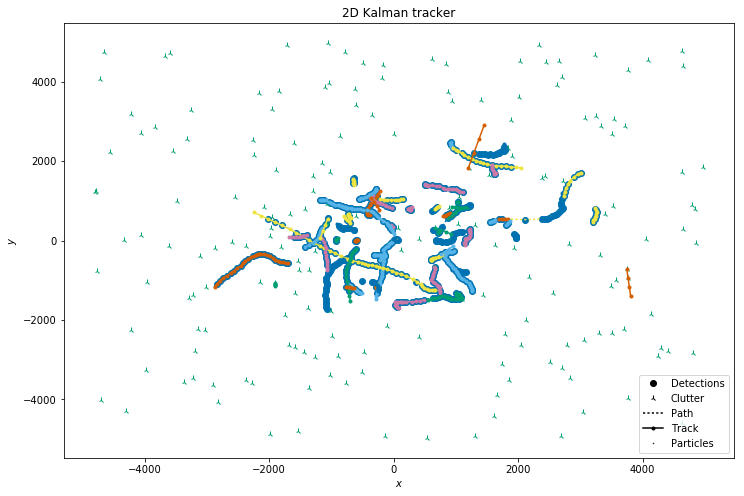

In [16]:
plot_data(kalman_tracks, groundtruth_paths, detections);plt.title("2D Kalman tracker");

Note: Colours are random to help differentiate overlapping data.

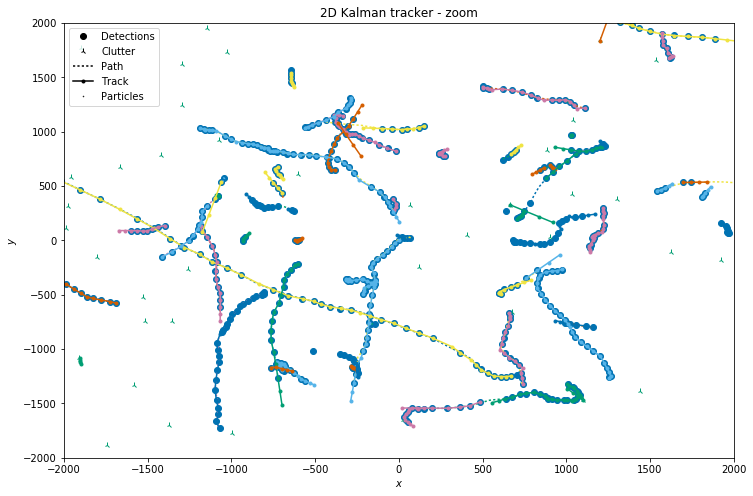

In [17]:
plot_data(kalman_tracks, groundtruth_paths, detections);plt.title("2D Kalman tracker - zoom");plt.xlim(-2000, 2000);plt.ylim(-2000, 2000);

At this point the *detections* produced from the *groundtruth_paths* have been used to create *tracks*.

The next step is to generate metrics to see how well that has been done.

# Setting up the metric manager

There are three components to consider when creating metrics:
- The MetricManager object parses and stores the input data (such as the tracks and groundtruth) and calls the MetricGenerators assigned to it
- The MetricGenerator object processes the data and produces Metrics.
- The Metric object stores the metric information

First we create the MetricGenerators, some of which have their own parameters that need defining.

BasicMetrics currently does very simple analysis of the tracks and truth: simply measuring the number of tracks, truth paths and the track/truth ratio.

OSPAMetric calculates the OSPA metric at each timestep (the average difference between state estimations and truth positions).

SiapMetrics computes the SIAP (Single Integrated Air Picture) metrics

In [18]:
from stonesoup.metricgenerator.basicmetrics import BasicMetrics
from stonesoup.metricgenerator.ospametric import OSPAMetric
from stonesoup.metricgenerator.tracktotruthmetrics import SIAPMetrics

basic_calculator = BasicMetrics()
ospa_calculator = OSPAMetric(
    c=10,p=1,measurement_model_track=measurement_model, measurement_model_truth=measurement_model)
siap_calculator = SIAPMetrics()

The metric manager is initialised with the MetricGenerators that it will be running. The data is then imported. When the data is imported, the class of the data is checked and stored appropriately (e.g. if a Track type data is imported then it is assumed that this is the track produced from a tracker).

The *add_data* function, by default, appends any additional data. Using the overwrite=True flag instead replaces the current data with the new data.

For the SIAP metrics we also requrie an associator to associate tracks to truths.

## Associators

An associator links together various objects, in this case ground truth and tracks. The associator is added to the metric manager and, when called, populates the internam *metric_manager.association_set*.

An *association_set*, as the name suggests, contains a set of associations (in *association_set.objects*) and also includes the ability to select from that set for associations at a given timstamp or including a given object.

An association includes the objects being associated and the time range over which the association is valid

In [19]:
from stonesoup.dataassociator.tracktotrack import EuclideanTrackToTruth

associator = EuclideanTrackToTruth(
    measurement_model_truth=measurement_model, measurement_model_track=measurement_model,
    association_threshold=30)

In [20]:
from stonesoup.metricgenerator.manager import SimpleManager
metric_manager = SimpleManager([basic_calculator,ospa_calculator, siap_calculator], associator=associator)
metric_manager.add_data([kalman_tracks, groundtruth_paths, detections])
metric_manager.associate_tracks()

# Generate the metrics

Running *generate_metrics* calls all of the metric generators stored in the manager. 

In [21]:
metrics = metric_manager.generate_metrics()

Most of the metrics are a simple value.

In [22]:
for metric in metrics:
    if metric.title not in ["OSPA distances"]:
        print(metric.title,":", metric.value)

SIAP LS : 0.835725677830941
SIAP S : 0.16417910447761194
Number of targets : 48
SIAP LT : 705.0
SIAP C : 0.9125925925925926
Number of tracks : 66
Track-to-target ratio : 1.375
SIAP A : 1.0


The OSPA metric is a list of the OSPA distance at each timestep

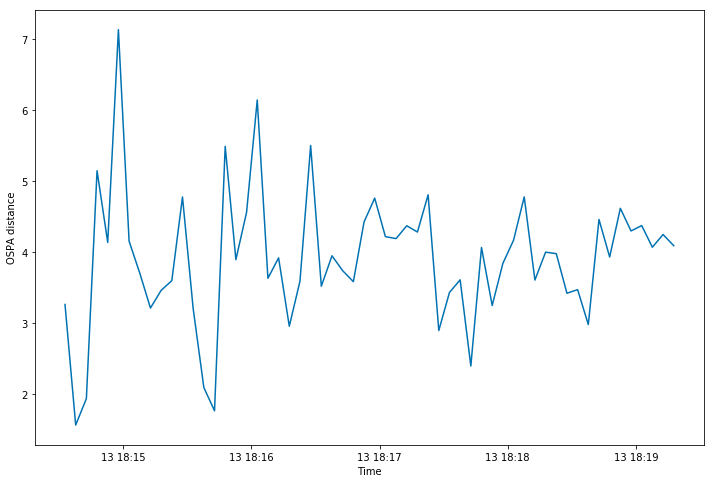

In [23]:
ospa_metric = [i for i in metrics if i.title == "OSPA distances"][0]

plt.plot([i.timestamp for i in ospa_metric.value], [i.value for i in ospa_metric.value])
plt.ylabel("OSPA distance")
plt.xlabel("Time");